## MLP From Scratch
Homework 1  
ECSE 552  
Gian Favero and Mohamed Mohamed  
February 5th, 2024  

### Objectives

The object of this notebook is to construct an MLP network from scratch without using autodifferentiation or optimization capabilities of higher-level libraries (PyTorch, TensorFlow, etc.). In other words, the gradients must be calculated and propogated through the network so as to implement stochastic gradient descent manually.

For simplification, the network has some constraints:

- The neural network has two hidden layers
- The network may have a fixed architecture
- Network parameters can be randomly initialized
- The output has 3 units
- All layers have sigmoid activation functions
- Batch size is 1
- The loss function is sum of squared errors (SSE) across the three outputs

### Getting Started

We begin by importing the necessary libraries for this implementation. In our case all we need is NumPy for the algorithmic operations and matplotlib for plotting loss and validation curves.

In [13]:
# imports
import numpy as np
import matplotlib.pyplot as plt

### Loading Data

The data provided for this part of the assignment consists of four .csv files: two data files and two label files for the training and validation sets. To aptly use our custom dataloader, we will append the labels as the last three columns of the data file. 

In [14]:
# Load in the training data .csv file
train_data = np.loadtxt('data/training_set.csv', delimiter=',')
train_labels = np.loadtxt('data/training_labels_bin.csv', delimiter=',')

# Concatenate the labels to the training data
train_data = np.concatenate((train_data, train_labels), axis=1)

# Do the same thing for validation data
val_data = np.loadtxt('data/validation_set.csv', delimiter=',')
val_labels = np.loadtxt('data/validation_labels_bin.csv', delimiter=',')
val_data = np.concatenate((val_data, val_labels), axis=1)

# Save the data to a .csv file
np.savetxt('data/train_data.csv', train_data, delimiter=',')
np.savetxt('data/val_data.csv', val_data, delimiter=',')

Given that we are working with tabular data provided as training and validation sets and labels. We can construct a dataloader that is capable of loading data from a specified .csv file(s), shuffling the instances, and doing normalization by feature. 

Normalization typically involves adjusting the values in the dataset so they share a common scale, without distorting differences in the ranges of values or losing information. A common approach is to scale the features to a range, or to standardize them to have a mean of 0 and a standard deviation of 1. This is important in machine learning applications for more efficient and stable training.

In [15]:
class DataLoader:
    """
    A custom data loader class for loading data from a .csv file.
    """
    def __init__(self, filename: str, shuffle: bool=True, normalize: bool=True) -> None:
        # Load data from file
        self.data = np.genfromtxt(filename, delimiter=',')
        self.features = self.data[:, :-3]
        self.labels = self.data[:, -3:]

        self.batch_size = 1 # batch size of 1 as per constraints
        self.shuffle = shuffle
        self.indexes = np.arange(self.features.shape[0])

        # Normalize data if required
        if normalize:
            self.features = self.normalize(self.features)

    def normalize(self, data: np.ndarray) -> np.ndarray:
        # Standardize data: mean of 0 and standard deviation of 1
        mean = np.mean(data, axis=0)
        std = np.std(data, axis=0)
        return (data - mean) / std
    
    def __len__(self) -> int:
        # Return the number of batches
        return int(np.ceil(len(self.features) / self.batch_size))

    def __iter__(self) -> 'DataLoader':
        self.indexes = np.arange(self.features.shape[0])
        # Shuffle data at the start of each iteration if required
        if self.shuffle:
            np.random.shuffle(self.indexes)
        return self

    def __next__(self) -> tuple:
        # If there's no more data to process, stop iteration
        if len(self.indexes) == 0:
            raise StopIteration

        # Select indexes for the next batch
        batch_indexes = self.indexes[:self.batch_size]
        self.indexes = self.indexes[self.batch_size:]

        # Return the batch of data
        return self.features[batch_indexes], self.labels[batch_indexes]

### MLP

We now move into defining the MLP net. 

#### Feedforward Process

The initial step of constructing a feedforward process is to construct a neuron. The constraints specify that each unit (hidden or other) is to have a sigmoid activation function. Thus, we can start there. The sigmoid function is defined as:

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

In [16]:
def sig(x: np.ndarray) -> np.ndarray:
    """
    Compute the sigmoid function for the input x.
    """
    return 1 / (1 + np.exp(-x))

The next process involves specifying an initialization method that dynamically allocates parameters for each layer based on a `layer_sizes` argument.

Weight Matrices $W^{(l)}$:
- Dimension Specification: For a given layer `l`, the corresponding weight matrix should have dimensions of `m` rows by `n` columns.
    - `m` represents the width of layer `(l-1)`.
    - `n` represents the width of layer `l`.
- Value Assignment: These matrices are filled with random values ranging between 0 and 1.
- Storage: Matrices are stored in an array for later use.

Hidden State Arrays $h^{(l)}$:
- Creation: Hidden state arrays are created for each layer, excluding the output layer.
- Initialization: These arrays are initially filled with zeros.

In [17]:
def init_net(layer_sizes: list) -> tuple:
    """
    Initialize the weights and hidden states for the neural network.

    Args:
        layer_sizes: A list containing the number of nodes in each layer of the network.
                     e.g. [784, 100, 10] for a network with 784 input nodes, 100 hidden nodes,
                     and 10 output nodes.

    Returns:
        weights: A list of numpy arrays containing the weights for each layer of the network.
                 e.g. weights[0] is the weight matrix for the first layer of the network.
        biases: A list of numpy arrays containing the bias terms for each layer of the network.
                e.g. biases[0] is the bias term for the first layer of the network.
        hidden_states: A list of numpy arrays containing the hidden states for each layer of the network.
                       e.g. hidden_states[0] is the hidden state for the first layer of the network.
    """
    # Initialize weights with random values. Note that the output layer does not have weights.
    weights = []
    for i in range(len(layer_sizes) - 1):
        weights.append(np.random.rand(layer_sizes[i], layer_sizes[i+1]))

    # Initialize bias terms with random values. Note that the output layer does not have bias terms.
    biases = []
    for i in range(len(layer_sizes) - 1):
        biases.append(np.random.rand(layer_sizes[i+1]))
    
    # Initialize hidden states with zeros. Note that the first hidden state is the input, and the last hidden state is the output layer.
    hidden_states = []
    for i in range(len(layer_sizes)):
        hidden_states.append(np.zeros(layer_sizes[i]))

    return weights, biases, hidden_states

We are now ready to implement a `forward` function to compute the network prediction. 

Key Points:

- Batch Size Constraint: The constraint on the batch size enforces that only one input is given per update.
- Input Representation: In this context, 'x' denotes a sample data point to feed through the network.
- Hidden States Update: Hidden states from 1 through `len(layer_sizes)` are updated in an iterative fashion.

The first hidden state is simply the input: $h^{(0)} = x$. For subsequent layers, the hidden state is defined as:

$$
a^{(l)} = W^{(l)} h^{(l-1)} + b^{(l)}
$$

Where $h^{(l)} = \sigma({a^{(l)}})$

In [18]:
def forward(x: np.ndarray, weights: list, hidden_states: list, biases: list) -> list:
    """
    Perform a forward pass through the network storing the hidden states and output.

    Args:
        x: The input data.
        weights: The weights of the network.
        hidden_states: The hidden states of the network.

    Returns:
        Updated hidden states of the network (pre-activation) and the output of the network.
    """
    hidden_states[0] = x
    for i in range(len(weights)):
        hidden_states[i+1] = np.dot(x, weights[i]) + biases[i]
        x = sig(hidden_states[i+1])

    output = x

    return hidden_states, output

#### Backpropagation

Training the network involves stochastic gradient descent in which all network weights are decremented by the gradient of the cost function with respect to the weight (multiplied by a learning rate hyperparameter). Deriving the gradient of the cost function with respect to each individual weight is analytically much less practical than using backpropagation which leverages the chain rule for on-the-fly gradient computation (sacrificing memory for computation). 

Given the constraint that all hidden units (and output units) have a sigmoid activation function, we only need to define one gradient function. Easy enough, the sigmoid function has a simple analytical gradient.

In [19]:
def sig_grad(x: np.ndarray) -> np.ndarray:
    """
    Compute the gradient of the sigmoid function for the input x.
    """
    return sig(x) * (1 - sig(x))

We also need to define a loss function for the output. Recall that it is the SSE across the three outputs. We can implement this as follows:

In [20]:
def loss(y: np.ndarray, y_hat: np.ndarray) -> float:
    """
    Compute the loss and gradient between the predicted and true labels.

    Args:
        y: The true labels.
        y_hat: The predicted labels (pre-activation).

    Returns:
        The loss and its gradient between the predicted and true labels.
    """
    loss_val = 0.5 * np.sum((y - y_hat) ** 2)
    loss_grad = y_hat - y
    return loss_val, loss_grad

We can now define a full backpropagation algorithm for updating each weight. The gradient of the SSE loss function with respect to each output node (i.e., each predicted value $\hat{y}_i $) is calculated as follows:
$$
\frac{\partial J}{\partial \hat{y}_i} = \frac{\partial}{\partial \hat{y}_i} \left( \frac{1}{2} \sum_{j=1}^{n} (y_j - \hat{y}_j)^2 \right)
$$

For the $i^{th}$ term:
$$
\frac{\partial J}{\partial \hat{y}_i} = - \frac{1}{2} \times 2 \times (y_i - \hat{y}_i) = \hat{y}_i - y_i
$$

The hidden layers are formulated as follows:
$$
a^{(l)} = W^{(l)}h^{(l-1)} + b^{(l)}, 
h^{(l)} = \sigma (a^{(l)})
$$

It can be formulated (as seen in the lecture) that the chain rule can be used to calculate the gradients pre-activation:
$$
\frac{\partial J}{\partial a^{(l)}} = \frac{\partial J}{\partial h^{(l)}} \cdot f'(a^{(l)})
$$

From here, the gradients of the weights and biases are easily derived:
$$
\frac{\partial J}{\partial W^{(l)}} = \frac{\partial J}{\partial a^{(l)}} \cdot h^{(l-1)T}, 
\frac{\partial J}{\partial b^{(l)}} = \frac{\partial J}{\partial a^{(l)}}
$$

And then finally, for the previous post-activation layer, $h^{(l-1)}$
$$
\frac{\partial J}{\partial h^{(l-1)}} = W^{(l)T} \cdot \frac{\partial J}{\partial a^{(l)}} 
$$

In [21]:
def backward(loss_grad: float, weights: list, biases: list, hidden_states: list, lr: float) -> tuple:
    """
    Perform a backward pass through the network updating the weights.

    Args:
        loss_grad: The gradient of the SSE loss for the output units.
        weights: The weights of the network.
        hidden_states: The hidden states of the network.
        lr: Learning rate for the update.

    Returns:
        Updated weights and biases of the network.
    """
    # Make an array of the same size as the hidden states to store the gradients
    pre_gradients = [np.zeros_like(h_state) for h_state in hidden_states]
    post_gradients = [np.zeros_like(h_state) for h_state in hidden_states]

    # Get the gradient of the loss with respect to the output layer
    post_gradients[-1] = loss_grad

    for i in range(len(hidden_states) - 1, 0, -1):
        # Compute the pre-activation gradient for the current layer
        pre_gradients[i] = post_gradients[i] * sig_grad(hidden_states[i])

        # Update the weights and biases for the current layer
        weights[i-1] -= lr * np.dot(hidden_states[i-1].T, pre_gradients[i])
        biases[i-1] -= lr * pre_gradients[i][0]

        # Compute the gradient of the loss with respect to the hidden states
        post_gradients[i-1] = np.dot(pre_gradients[i], weights[i-1].T)

    return weights, biases

### Training

We will translate the code into a class for organization. 

In [22]:
class MLP:
    def __init__(self, layer_sizes: list, lr: float=0.01) -> None:
        self.lr = lr

        # Initialize weights with random values. Note that the output layer does not have weights.
        self.weights = []
        for i in range(len(layer_sizes) - 1):
            self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(1 / layer_sizes[i]))

        # Initialize bias terms with random values. Note that the output layer does not have bias terms.
        self.biases = []
        for i in range(len(layer_sizes) - 1):
            self.biases.append(np.random.rand(layer_sizes[i+1]))
        
        # Initialize hidden states with zeros. Note that the first hidden state is the input, and the last hidden state is the output layer.
        self.hidden_states = []
        for i in range(len(layer_sizes)):
            self.hidden_states.append(np.zeros(layer_sizes[i]))

    def _forward(self, x: np.ndarray) -> list:
        self.hidden_states[0] = x
        for i in range(len(self.weights)):
            self.hidden_states[i+1] = np.dot(x, self.weights[i]) + self.biases[i]
            x = sig(self.hidden_states[i+1])

        output = sig(self.hidden_states[-1])

        return output
    
    def _backward(self, loss_grad: float) -> tuple:
        # Make an array of the same size as the hidden states to store the gradients
        self.pre_gradients = [np.zeros_like(h_state) for h_state in self.hidden_states]
        self.post_gradients = [np.zeros_like(h_state) for h_state in self.hidden_states]

        # Get the gradient of the loss with respect to the output layer
        self.post_gradients[-1] = loss_grad

        for i in range(len(self.hidden_states) - 1, 0, -1):
            # Compute the pre-activation gradient for the current layer
            self.pre_gradients[i] = self.post_gradients[i] * sig_grad(self.hidden_states[i])

            # Update the weights and biases for the current layer
            self.weights[i-1] -= self.lr * np.dot(self.hidden_states[i-1].T, self.pre_gradients[i])
            self.biases[i-1] -= self.lr * self.pre_gradients[i][0]

            # Compute the gradient of the loss with respect to the hidden states
            self.post_gradients[i-1] = np.dot(self.pre_gradients[i], self.weights[i-1].T)
    
    def _loss(self, y: np.ndarray, y_hat: np.ndarray) -> float:
        loss_val = 0.5 * np.sum((y - y_hat) ** 2)
        loss_grad = y_hat - y
        return loss_val, loss_grad

    def train(self, train_loader: DataLoader, val_loader: DataLoader, epochs: int=10) -> tuple:
        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            epoch_loss = 0
            for x, y in train_loader:
                # Forward pass
                y_hat = self._forward(x)[-1]

                # Compute loss
                loss_val, loss_grad = self._loss(y, y_hat)
                epoch_loss += loss_val

                # Backward pass
                self._backward(loss_grad)

            # Compute average loss for the epoch
            epoch_loss /= len(train_loader)
            train_losses.append(epoch_loss)

            # Compute validation loss
            val_loss = 0
            for x, y in val_loader:
                y_hat = self._forward(x)[-1]
                val_loss += self._loss(y, y_hat)[0]
            val_loss /= len(val_loader)
            val_losses.append(val_loss)

            print(f'Epoch {epoch+1}: Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f}')
            
            # Reduce learning rate after 10 epochs
            if epoch > 5 and epoch % 5 == 0:
                self.lr /= 3

        return train_losses, val_losses

### Performance Analysis

We construct a MLP network with 50 hidden units in each of the two hidden layers. In addition, the learning rate is initialized to 0.01 and divided by three every five epochs after a five warmup epoch period has passed. To investigate if the network is learning correctly, a few pieces of analysis are critical:

- Is the network able to overfit and achieve near zero loss on the training set?
- Is the training loss generally decreasing over time?

We investigate these critical questions through observance of the training and validation losses over time (epochs).

Epoch 1: Train Loss: 0.2026 | Val Loss: 0.1466
Epoch 2: Train Loss: 0.0563 | Val Loss: 0.1126
Epoch 3: Train Loss: 0.0302 | Val Loss: 0.1159
Epoch 4: Train Loss: 0.0196 | Val Loss: 0.1051
Epoch 5: Train Loss: 0.0143 | Val Loss: 0.0996
Epoch 6: Train Loss: 0.0111 | Val Loss: 0.1024
Epoch 7: Train Loss: 0.0089 | Val Loss: 0.0917
Epoch 8: Train Loss: 0.0074 | Val Loss: 0.0996
Epoch 9: Train Loss: 0.0061 | Val Loss: 0.1015
Epoch 10: Train Loss: 0.0053 | Val Loss: 0.1026
Epoch 11: Train Loss: 0.0046 | Val Loss: 0.0954
Epoch 12: Train Loss: 0.0038 | Val Loss: 0.0995
Epoch 13: Train Loss: 0.0036 | Val Loss: 0.0974
Epoch 14: Train Loss: 0.0035 | Val Loss: 0.0991
Epoch 15: Train Loss: 0.0034 | Val Loss: 0.1007
Epoch 16: Train Loss: 0.0033 | Val Loss: 0.0989
Epoch 17: Train Loss: 0.0031 | Val Loss: 0.0995
Epoch 18: Train Loss: 0.0030 | Val Loss: 0.0985
Epoch 19: Train Loss: 0.0030 | Val Loss: 0.0984
Epoch 20: Train Loss: 0.0030 | Val Loss: 0.0997


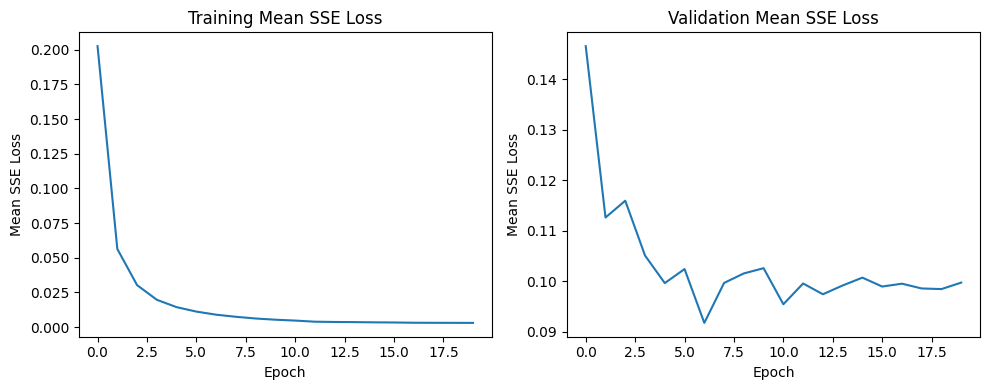

In [23]:
# Load data
train_loader = DataLoader('data/train_data.csv')
val_loader = DataLoader('data/val_data.csv')

# Initialize MLP
mlp = MLP([354, 50, 50, 3])

# Train MLP
train_losses, val_losses = mlp.train(train_loader, val_loader, epochs=20)

# Plot losses on two separate subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(train_losses)
ax1.set_title('Training Mean SSE Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean SSE Loss')

ax2.plot(val_losses)
ax2.set_title('Validation Mean SSE Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean SSE Loss')

plt.tight_layout()
plt.show()

### Results

The results indicate that the MLP network is indeed able to learn the data with the specified configuration. The average training and validation SSE losses start moderately high, but decrease in response to the stochastic gradient descent algorithm. As the weights and biases of the model become more fine-tuned, the training loss converges at a near-zero level, while the validation loss plateaus as well. 

While the network is clearly able to learn from the training data, its performance in terms of generalizability could be better. This is apparent because of the high bias between the training and validation losses. Network architecture, learning rate optimization, and regularization are a few topics of improvement for the shortcomings of the MLP model developed here. 

We can additionally create a PyTorch model of the same structure for comparison.

In [25]:
# Make a PyTorch MLP of the same structure
import torch
import torch.nn as nn
import torch.optim as optim

class PyTorchMLP(nn.Module):
    def __init__(self):
        super(PyTorchMLP, self).__init__()
        self.fc1 = nn.Linear(354, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 3)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
    
pytorch_mlp = PyTorchMLP()
criterion = nn.MSELoss()
optimizer = optim.SGD(pytorch_mlp.parameters(), lr=0.01)

# Train PyTorch MLP
pytorch_train_losses = []
pytorch_val_losses = []

for epoch in range(20):
    epoch_loss = 0
    for x, y in train_loader:
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        optimizer.zero_grad()
        y_hat = pytorch_mlp(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    pytorch_train_losses.append(epoch_loss)

    val_loss = 0
    for x, y in val_loader:
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        y_hat = pytorch_mlp(x)
        val_loss += criterion(y_hat, y).item()
    val_loss /= len(val_loader)
    pytorch_val_losses.append(val_loss)

# Print the final losses
print(f'Final Training Loss: {train_losses[-1]:.4f} | Final Validation Loss: {val_losses[-1]:.4f}')
print(f'PyTorch Final Training Loss: {pytorch_train_losses[-1]:.4f} | PyTorch Final Validation Loss: {pytorch_val_losses[-1]:.4f}')

Final Training Loss: 0.0030 | Final Validation Loss: 0.0997
PyTorch Final Training Loss: 0.0077 | PyTorch Final Validation Loss: 0.0725


We observe that our MLP from scratch reaches virtually the same performance as the PyTorch implementation after training for 20 epochs, therefore providing some validation that the implementation is correct.